# PMF function

In [5]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
             error**k *
             (1-error)**(n_classifier -k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier =11, error = 0.25)

0.03432750701904297

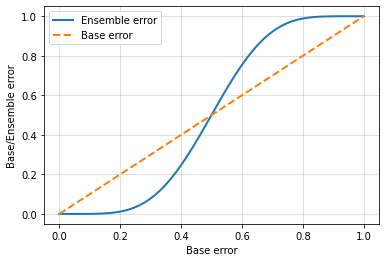

In [6]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier = 11, error = error)
              for error in error_range]
plt.plot(error_range, ens_errors, label = 'Ensemble error', linewidth = 2)
plt.plot(error_range, error_range, linestyle = '--', label = 'Base error', linewidth = 2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc = 'upper left')
plt.grid(alpha = 0.5)
plt.show()

In [7]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
                      weights = [0.2, 0.2, 0.6]))

1

In [8]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [9]:
np.argmax(p)

0

In [13]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    '''
    다수결 투표 앙상블 분류기
    
    매개변수
    classifiers : 배열 타입, 크기 = [n_classifiers]
                  앙상블에 사용할 분류기

    vote : str, {'classlabel', 'probability'}
    기본값 : 'classlabel'
    'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스
    'probability'면 확률 합이 가장 큰 인덱스로 예측
    
    weights : 배열 타입, 크기 = [n_classifiers]
    
    선택사항, 기본값 : None
    
    'int'또는'float'값의 리스트가 주어지면 분류기가 이 중요도로 가중치됨
    'weights = None'이면 동일취급
    '''
    
    def __init__(self, classifiers, vote = 'classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        else:
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights = self.weights)),
                                           axis = 1, arr = predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights = self.weights)
        return avg_proba
    
    def get_params(self, deep = True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep = False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep = True)):
                    out[f"{name}__{key}"] = value
                    
        return out

In [14]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1, stratify = y)

### logistic regression, knn, decision tree

### 앙상블로 묶기 전 훈련 세트 cv = 10

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 0.001, random_state = 1)

clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)

clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
# decisiontree는 표준화가 필요없다!

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-겹 교차검증: \n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-겹 교차검증: 

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


### 앙상블 분류기 연결

In [18]:
mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf, X=X_train, y = y_train, cv = 10, scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


In [44]:
from sklearn.ensemble import VotingClassifier

models = [pipe1, clf2, pipe3]

hard_vote  = VotingClassifier(models, voting='hard')
asdf = cross_val_score(estimator = hard_vote, X = X_train, y= y_train, cv = 10, scoring = 'roc_auc')
print(round(scores.mean(), 2))

0.98


c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\sklearn\ensemble\_voting.py", line 292, in fit
    return super().fit(X, transformed_y, sample_weight)
  File "c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\sklearn\ensemble\_voting.py", line 66, in fit
    names, clfs = self._validate_estimators()
  File "c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\sklearn\ensemble\_base.py", line 225, in _validate_estimators
    names, estimators = zip(*self.estimators)
TypeError: zip argument #2 must support iteration

  FitFailedWarning)
c

### 앙상블 분류기 평가와 튜닝

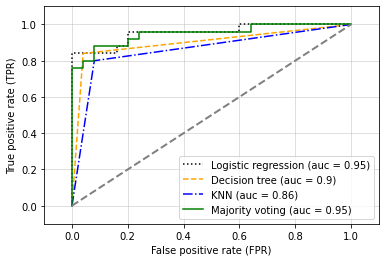

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr, tpr, color = clr, linestyle = ls, label = f"{label} (auc = {round(roc_auc, 2)})")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

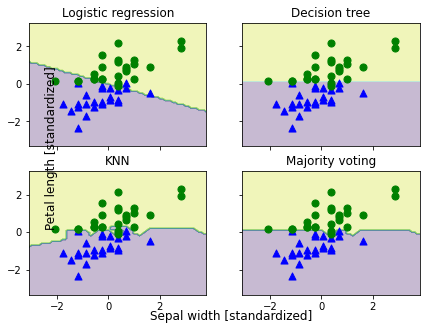

In [20]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

x_min = X_train_std[:, 0].min() -1
x_max = X_train_std[:, 0].max() +1
y_min = X_train_std[:, 1].min() -1
y_max = X_train_std[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(2, 2, sharex = 'col', sharey = 'row', figsize = (7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c = 'blue', marker ='^', s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c = 'green', marker ='o', s = 50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s = 'Sepal width [standardized]', ha = 'center', va = 'center', fontsize = 12)
plt.text(-10.5, 4.5, s = 'Petal length [standardized]', ha = 'center', va = 'center', fontsize = 12, rotation = 90)
plt.show()

In [22]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf',
                  LogisticRegression(C=0.001, random_state=1,
                                     solver='liblinear')]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1, solver='liblinear')]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1, solver='liblinear'),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf_

In [24]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth':[1, 2], 'pipeline-1__clf__C':[0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator = mv_clf, param_grid = params, cv = 10, scoring = 'roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1,
                                                                                               solver='liblinear')]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
       

# bagging

In [30]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', '0D280/0D315 of diluted wines',
                   'Proline']

# make exception of class 1
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', '0D280/0D315 of diluted wines']].values

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

In [38]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 1, max_depth = None)
bag = BaggingClassifier(base_estimator = tree, n_estimators = 500, max_samples = 1.0, max_features = 1.0,
                        bootstrap = True, bootstrap_features = False, n_jobs = -1, random_state = 1)

# 정확도 비교 배깅, 결정나무
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f' %(tree_train, tree_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833


In [39]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('배킹 훈련 정확도/테스트 정확도 %.3f/%.3f' %(bag_train, bag_test))

배킹 훈련 정확도/테스트 정확도 1.000/0.917


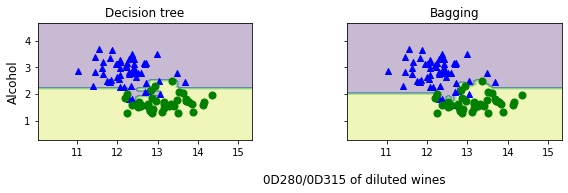

In [42]:
x_min = X_train[:, 0].min() -1
x_max = X_train[:, 0].max() +1
y_min = X_train[:, 1].min() -1
y_max = X_train[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, sharex = 'col', sharey = 'row', figsize = (8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c = 'blue', marker ='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c = 'green', marker ='o', s = 50)
    
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -1.2, s = '0D280/0D315 of diluted wines', ha = 'center', va = 'center', fontsize = 12)
plt.tight_layout()
plt.show()

# Boosting

In [45]:
# 깊이가 1인 결정트리로 트리 500개로 구성된 adaboost
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'entropy', random_state =1, max_depth = 1)
ada = AdaBoostClassifier(base_estimator = tree, n_estimators = 500, learning_rate = 0.1, random_state = 1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(tree_train, tree_test)

0.9157894736842105 0.875


In [46]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(ada_train, ada_test)

1.0 0.9166666666666666


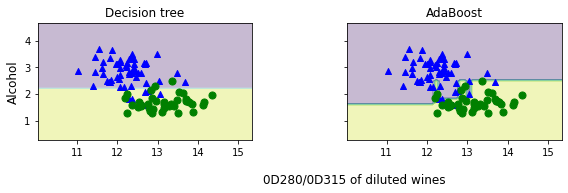

In [47]:
x_min = X_train[:, 0].min() -1
x_max = X_train[:, 0].max() +1
y_min = X_train[:, 1].min() -1
y_max = X_train[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, sharex = 'col', sharey = 'row', figsize = (8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c = 'blue', marker ='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c = 'green', marker ='o', s = 50)
    
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -1.2, s = '0D280/0D315 of diluted wines', ha = 'center', va = 'center', fontsize = 12)
plt.tight_layout()
plt.show()

## Gradient boosting

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators = 20, random_state = 42)
gbrt.fit(X_train, y_train)
gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)
print('트리 개수', gbrt.n_estimators_)

트리 개수 20


In [49]:
print(gbrt_train_score, gbrt_test_score)

1.0 0.9166666666666666
